In [14]:
import time
start_time = time.time()
import warnings
from urllib3.exceptions import InsecureRequestWarning

# Suppress only the specific warning
warnings.simplefilter('ignore', InsecureRequestWarning)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,Input,Model
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [15]:
def generate_features(N, C, D):
    continuous_features = np.zeros((N, C))
    for i in range(C):
        if i % 3 == 0:
            continuous_features[:, i] = np.random.normal(loc=0, scale=0.3,size=N)
        elif i % 3 == 1:
            continuous_features[:, i] = np.random.uniform(-1,1,size=N)
        else:
            continuous_features[:, i] = np.random.normal(loc=0, scale=0.3,size=N)
            # continuous_features[:, i] = np.random.gamma(shape=2, scale=1,size=N)
    binary_features = np.zeros((N,D))
    for i in range(D):
        binary_features[:,i]=np.random.choice([0,1],p=[0.5,0.5],size=N)
    return np.hstack((continuous_features, binary_features))
def generate_t(N):
    tvalues=[]
    for i in range(N):
        tvalues.append(random.choice([0,0.128,0.268,0.358,0.5]))
    return np.array(tvalues)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

def abs_activation(x):
    return tf.math.abs(x)

def build_model(C, D):
    # Input layer
    input_layer = layers.Input(shape=(C + D,))
    # hidden1 = layers.Dropout(dropput_perc)(input_layer)
    # Hidden layers
    hidden1 = layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(input_layer)
    hidden2 = layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden1)
    hidden2 = layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)

    # Output layers with abs_activation
    alpha = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    beta = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    theta = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    # gamma = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    gamma = layers.Dense(1, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.4))(hidden2)
    # Extract features from input
    feature_c1 = layers.Lambda(lambda x: tf.expand_dims(x[:, C], axis=-1))(input_layer)
    feature_c2 = layers.Lambda(lambda x: tf.expand_dims(x[:, C + 1], axis=-1))(input_layer)

    # Gamma adjustment function
    def gamma_adjustment(inputs):
        gamma, feature_c1 = inputs
        gamma_adjust = gamma * (2*feature_c1-1)
        return gamma_adjust

    adjusted_gamma = layers.Lambda(gamma_adjustment, output_shape=(None, 1))([gamma, feature_c1])

    # Custom sensitivity scaling layer
    class SensitivityScalingLayer(layers.Layer):
        def call(self, inputs):
            alpha, beta, theta, sensitive = inputs
            scaling_factor = sensitive * 0.5 + 0.5
            adjusted_alpha = alpha * scaling_factor
            adjusted_beta = beta * scaling_factor
            adjusted_theta = theta * scaling_factor
            return adjusted_alpha, adjusted_beta, adjusted_theta

    # Apply sensitivity scaling
    adjusted_alpha, adjusted_beta, adjusted_theta = SensitivityScalingLayer()([alpha, beta, theta, feature_c2])

    # Define the model
    # model = models.Model(inputs=input_layer, outputs=[adjusted_alpha, adjusted_beta, adjusted_theta, adjusted_gamma])
    model = models.Model(inputs=input_layer,outputs =[alpha,beta,theta,gamma])
    return model


In [17]:
def predict_y(model, x, t):
    alpha,beta,theta,gamma = model.predict(x)
    alpha = alpha.reshape(-1)
    beta = beta.reshape(-1)
    theta = theta.reshape(-1)
    gamma = gamma.reshape(-1)

    # Calculate y using scaled t and updated alpha, beta, theta, and gamma
    y = t * t * t * alpha + beta * t * t + theta * t + gamma
    plt.hist(y)
    plt.show()
    y = 1 / (1 + np.exp(-y))  # Apply logistic to ensure outputs are in [0, 1]
    return y



In [18]:

C = 50  # Number of continuous variables
D = 20    # Number of binary discrete variables


In [19]:
N = 20000
exp_t_values = generate_t(N)
x = generate_features(N, C, D)

model_date_generation = build_model(50, 20)


In [20]:
alpha, beta,theta,gamma = model_date_generation.predict(x)
alpha = alpha.reshape(-1)
beta = beta.reshape(-1)
theta = theta.reshape(-1)
gamma = gamma.reshape(-1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


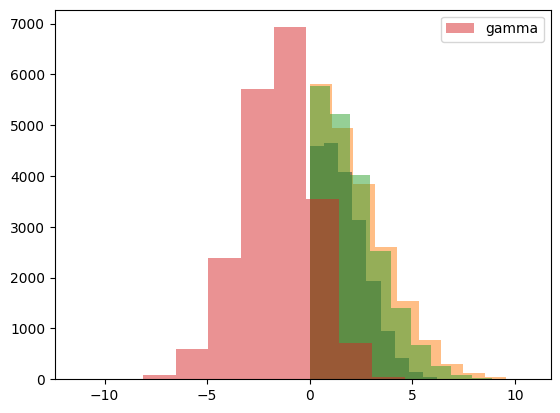

In [21]:
plt.hist(alpha)
plt.hist(beta,alpha=0.5)
plt.hist(theta,alpha=0.5)
plt.hist(gamma,alpha=0.5,label='gamma')
plt.legend()
plt.show()

In [22]:
alpha.mean(),beta.mean(),theta.mean(),gamma.mean()

(1.675992, 2.2940402, 2.0564303, -1.5565648)

In [23]:
alpha.var(),beta.var(),theta.var(),gamma.var()

(1.3239982, 2.970415, 2.3026226, 3.10058)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


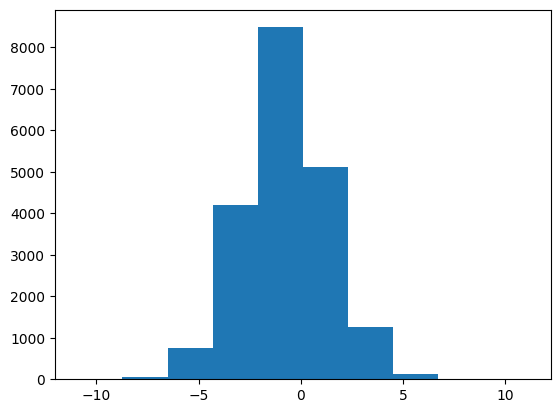

array([0.65003272, 0.67317724, 0.25835638, ..., 0.00934564, 0.13710005,
       0.88924254])

In [24]:
predicted_y = predict_y(model_date_generation, x, exp_t_values)
predicted_y

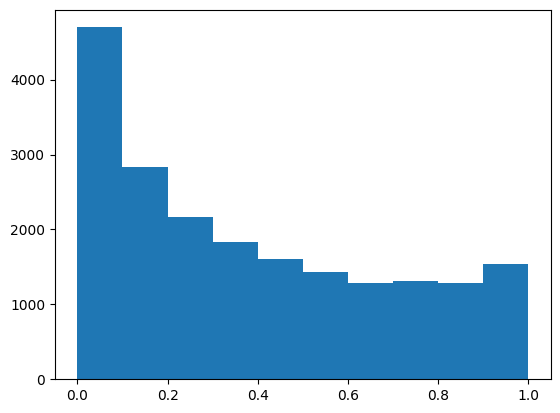

In [25]:
plt.hist(predicted_y)
plt.show()

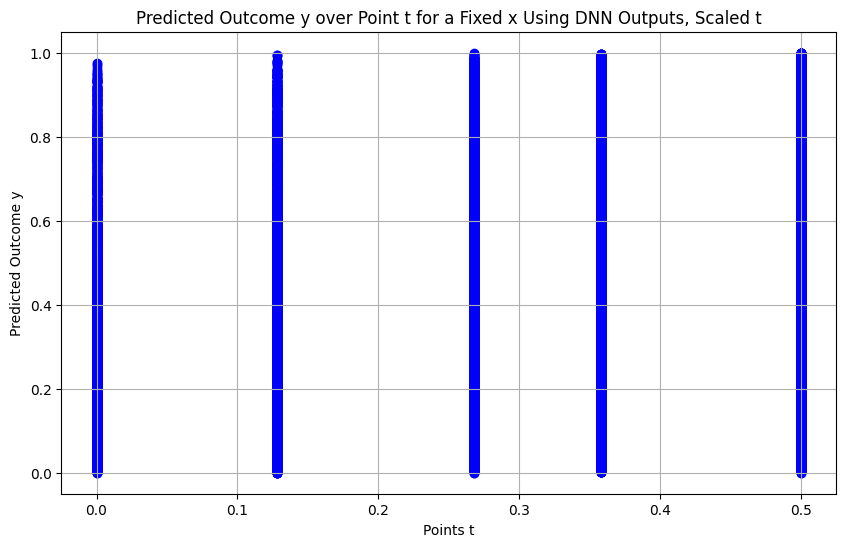

In [26]:

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(exp_t_values, predicted_y, color='blue')
plt.title('Predicted Outcome y over Point t for a Fixed x Using DNN Outputs, Scaled t')
plt.xlabel('Points t')
plt.ylabel('Predicted Outcome y')
plt.grid(True)
plt.show()

In [27]:
df = pd.DataFrame(x, columns=[f'Feature_{i+1}' for i in range(C + D)])
df['t'] = exp_t_values.flatten()
df['y'] = predicted_y
df['is_upload'] = 0

df.loc[df['y']>=0.5,'is_upload']=1

df['is_upload'].value_counts()

is_upload
0    13137
1     6863
Name: count, dtype: int64

In [28]:
df['treatment']=0
df.loc[df['t']>0,'treatment']=1

In [29]:
for i in [0,0.128,0.268,0.358,0.5]:
    subdata1 = df.loc[(df['t']==0)|(df['t']==i)]
    res = sm.OLS.from_formula('is_upload ~ 1 + treatment', data=subdata1).fit()
#         print(res.get_robustcov_results().summary2(float_format="%.6f"))
    print('coef of intercept:', '%.8f'%res.params['Intercept'])
    print('coef of treatment:', '%.8f'%res.params['treatment'])
    print('pvalues of treatment:', '%.2f'%res.pvalues['treatment'])
    print('res:', '{:.2%}'.format(res.params['treatment']/res.params['Intercept']) )

coef of intercept: 0.17516406
coef of treatment: 0.00000000
pvalues of treatment: nan
res: 0.00%
coef of intercept: 0.17516406
coef of treatment: 0.07179850
pvalues of treatment: 0.00
res: 40.99%
coef of intercept: 0.17516406
coef of treatment: 0.17765801
pvalues of treatment: 0.00
res: 101.42%
coef of intercept: 0.17516406
coef of treatment: 0.23128111
pvalues of treatment: 0.00
res: 132.04%
coef of intercept: 0.17516406
coef of treatment: 0.35606280
pvalues of treatment: 0.00
res: 203.27%


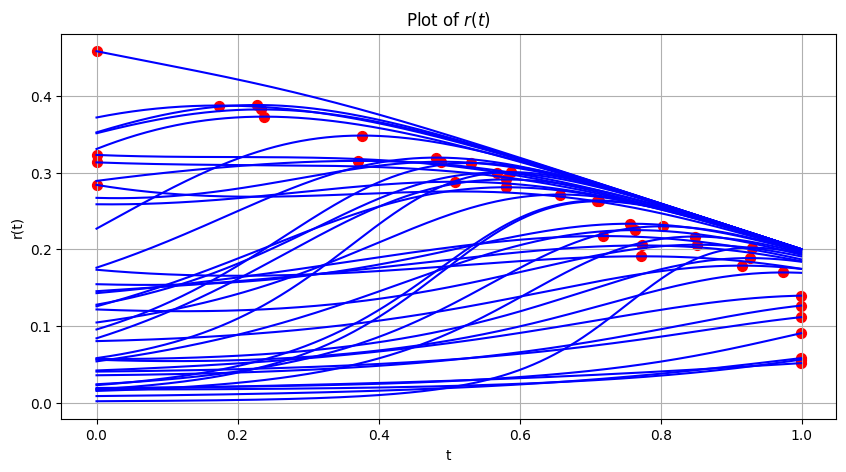

In [30]:
# Define the function y(t) and r(t)
def y(t,alpha,beta,theta,gamma):
    u =  t * t * t * alpha + beta * t * t + theta * t + gamma
    return 1 / (1 + np.exp(-u))
author_value = 0.3

def r(t,alpha,beta,theta,gamma):
    return y(t,alpha,beta,theta,gamma) * (0.5- author_value* t)

# Define the range for t
t_values = np.arange(0, 1, 0.001)



# Plotting
plt.figure(figsize=(10, 5))
for j in range(40):
    alpha0, beta0,theta0,gamma0 =alpha[j], beta[j],theta[j],gamma[j]
    r_values = r(t_values,alpha0,beta0,theta0,gamma0)
    max_r = np.max(r_values)
    max_t = t_values[np.argmax(r_values)]
    plt.plot(t_values, r_values, color='blue')
    plt.scatter(max_t, max_r, color='red', s=50)
plt.title("Plot of $r(t)$")
plt.xlabel("t")
plt.ylabel("r(t)")
plt.grid(True)
plt.show()


In [31]:
df.columns

Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15',
       'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20',
       'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25',
       'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30',
       'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35',
       'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40',
       'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45',
       'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50',
       'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55',
       'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60',
       'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65',
       '

In [32]:
df['wrong_groupidx']=df.groupby([f'Feature_{C+3}',f'Feature_{C+4}']).ngroup()
df['right_groupidx']=df.groupby([f'Feature_{C+1}',f'Feature_{C+2}']).ngroup()
df['noise_groupidx']=df.groupby([f'Feature_{C+D-1}',f'Feature_{C+D}']).ngroup()
df['rightnoise_groupidx']=df.groupby([f'Feature_{C+1}',f'Feature_{C+D}']).ngroup()

In [33]:

optimal_values = []
optimal_t = []
for j in range(N):
    alpha0, beta0,theta0,gamma0 =alpha[j], beta[j],theta[j],gamma[j]
    r_values = r(t_values,alpha0,beta0,theta0,gamma0)
    max_r = np.max(r_values)
    max_t = t_values[np.argmax(r_values)]
    optimal_values.append(max_r)
    optimal_t.append(max_t)

In [34]:
df['optimal_t'] = optimal_t
df['optimal_r'] = optimal_values
df[['optimal_t','optimal_r']]

,optimal_t,optimal_r
0,0.508,0.288308
1,0.000,0.313555
2,0.852,0.206068
3,0.999,0.139571
4,0.999,0.126613
...,...,...
19995,0.420,0.351816
19996,0.999,0.136753
19997,0.999,0.065626
19998,0.644,0.280821


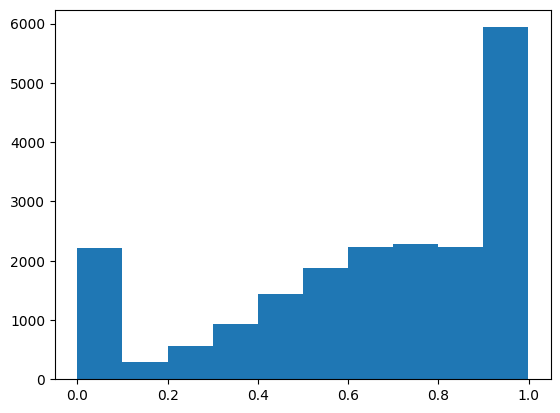

In [35]:
plt.hist(df['optimal_t'])
plt.show()

In [36]:
df.groupby([f'Feature_{C+1}',f'Feature_{C+2}'])['optimal_t'].agg({'mean','std'})

std      mean
Feature_51 Feature_52                    
0.0        0.0         0.316296  0.684986
           1.0         0.325945  0.645727
1.0        0.0         0.312371  0.662143
           1.0         0.313695  0.627922

In [37]:
tvar=['t']
xvar = [f'Feature_{i+1}' for i in range(C + D)]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


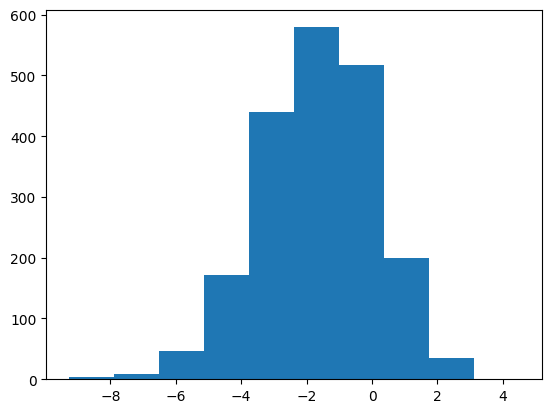

In [38]:
#generate validation data
N_test = 2000
x_validation = generate_features(N_test, C, D)

alpha_val, beta_val,theta_val,gamma_val = model_date_generation.predict(x_validation)


alpha_val = alpha_val.reshape(-1)
beta_val = beta_val.reshape(-1)
theta_val = theta_val.reshape(-1)
gamma_val = gamma_val.reshape(-1)
optimal_values = []
optimal_t = []

val_y = predict_y(model_date_generation, x_validation, np.zeros(N_test))

for j in range(N_test):
    alpha0, beta0,theta0,gamma0 =alpha_val[j], beta_val[j],theta_val[j],gamma_val[j]
    r_values = r(t_values,alpha0,beta0,theta0,gamma0)
    max_r = np.max(r_values)
    max_t = t_values[np.argmax(r_values)]
    optimal_values.append(max_r)
    optimal_t.append(max_t)
df_val = pd.DataFrame(x_validation, columns=[f'Feature_{i+1}' for i in range(C + D)])
df_val['optimal_t'] = optimal_t
df_val['optimal_r'] = optimal_values
df_val['y']=val_y
df_val[tvar]=0.0

In [39]:
df_train,df_test = train_test_split(df.sample(20000),test_size=1/2, random_state=5293)

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

dnn_x_train = df_train[xvar]
dnn_t_train = df_train[tvar]
dnn_y_train = df_train['is_upload'].astype('int')
printedResult_2000=[]

## DLPT

In [40]:
def dnn_cubic(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')

    t_sq = layers.Multiply()([input2_,input2_])
    t3 = layers.Multiply()([input2_,t_sq])

    a = layers.Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal())(input1_)
    a = layers.Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal())(a)
    a = layers.Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal())(a)
    paraa = layers.Dense(1,name='parameter_a')(a)
    parab = layers.Dense(3,name='parameter_bcd')(a)

    t = layers.concatenate([input2_,t_sq,t3])
    def custom_multiply_and_sum(inputs):
        parab, t = inputs
        return tf.reduce_sum(parab * t, axis=-1, keepdims=True) 

    bbt = tf.keras.layers.Lambda(custom_multiply_and_sum)([parab, t])
    abcdt = layers.Add(name='u')([paraa,bbt])

    output_ = layers.Dense(1,use_bias = False,trainable=False,activation='sigmoid',
                   kernel_initializer = tf.keras.initializers.constant(1),
                   name='sigmoid_function')(abcdt)
#     output_ = layers.Dense(1,use_bias=False,name='output_sigmoid')(output_)
    model = Model(inputs=[input1_,input2_],outputs=[output_])
    model.summary()
    return model
model_cubic_random_mask = dnn_cubic(xvar,tvar)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │        710 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10)        │        110 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ treatment_input[… │
│                     │                   │            │ treatment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10)        │        110 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1)         │          0 │ treatment_input[… │
│ (Multiply)          │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parameter_bcd       │ (None, 3)         │         33 │ dense_16[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ treatment_input[… │
│ (Concatenate)       │                   │            │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parameter_a (Dense) │ (None, 1)         │         11 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1)         │          0 │ parameter_bcd[0]… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u (Add)             │ (None, 1)         │          0 │ parameter_a[0][0… │
│                     │                   │            │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_function    │ (None, 1)         │          1 │ u[0][0]           │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 975 (3.81 KB)

 Trainable params: 974 (3.80 KB)

 Non-trainable params: 1 (4.00 B)

In [41]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [42]:
loss = tf.keras.losses.BinaryCrossentropy()
from tensorflow.keras.optimizers import Adagrad,Adam,SGD
# opt = SGD(learning_rate=0.005)


def weighted_mse_class(class_weights):
    def loss_fn(y_true, y_pred):
        weights = tf.where(tf.equal(y_true, 1), class_weights[1], class_weights[0])
        error = tf.square(y_true - y_pred)
        weighted_error = weights * error
        return tf.reduce_mean(weighted_error)
    return loss_fn

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=dnn_y_train.unique(),
    y=dnn_y_train
)
# class_weights = {0:np.mean(dnn_y_train), 1: (1-np.mean(dnn_y_train))}
# class_weights = np.log(class_weights+1)
# class_weights = dict(zip(np.array([0,1]), class_weights))
class_weights = {0:1,1:1}
loss_fn = weighted_mse_class(class_weights)

# model_cubic_random_mask.compile(optimizer = opt,loss = loss,metrics=METRICS)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitors validation loss
    patience=20,           # Number of epochs with no improvement after which to stop
    restore_best_weights=True  # Restores the best weights after stopping
)

from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch, lr):
    # Reduce learning rate by half every 8 epochs
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.5
    return lr
def exponential_decay(epoch, lr):
    initial_lr = 0.01
    k = 0.05  # Decay rate
    return initial_lr * np.exp(-k * epoch)

lr_scheduler = LearningRateScheduler(exponential_decay)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_cubic_random_mask.compile(optimizer = opt,loss = 'mse',metrics=METRICS)
history = model_cubic_random_mask.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=200,batch_size=32,\
                                      validation_split=0.1,callbacks=[early_stopping])

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6349 - auc: 0.5550 - fn: 1253.4983 - fp: 382.2686 - loss: 0.2353 - prc: 0.3997 - precision: 0.4483 - recall: 0.2260 - tn: 2593.8445 - tp: 314.1060 - val_accuracy: 0.6780 - val_auc: 0.5664 - val_fn: 294.0000 - val_fp: 28.0000 - val_loss: 0.2235 - val_prc: 0.3897 - val_precision: 0.5000 - val_recall: 0.0870 - val_tn: 650.0000 - val_tp: 28.0000
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.6589 - auc: 0.5691 - fn: 1461.3640 - fp: 93.7880 - loss: 0.2258 - prc: 0.4067 - precision: 0.4973 - recall: 0.0634 - tn: 2890.4204 - tp: 98.1449 - val_accuracy: 0.6830 - val_auc: 0.5905 - val_fn: 299.0000 - val_fp: 18.0000 - val_loss: 0.2174 - val_prc: 0.4122 - val_precision: 0.5610 - val_recall: 0.0714 - val_tn: 660.0000 - val_tp: 23.0000
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.6635 - auc: 0.6061 - fn: 1462.3038 - fp: 70.7597 - loss: 0.2202 - prc: 0.4432 - precision: 0.5744 - recall: 0

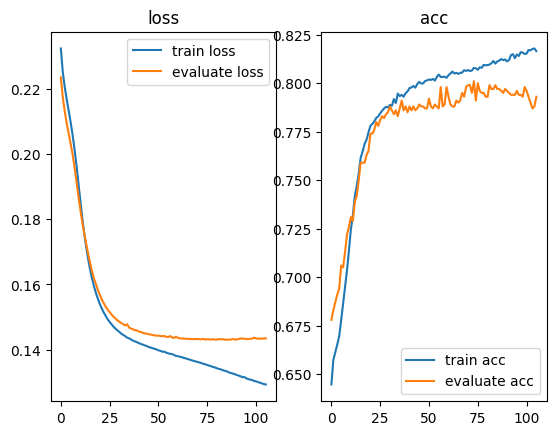

In [43]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
plt.figure()
plt.subplot(121)
plt.plot(loss,label='train loss')
plt.plot(val_loss,label = 'evaluate loss')
plt.legend()
plt.title('loss')
plt.subplot(122)
plt.plot(acc,label='train acc')
plt.plot(val_acc,label = 'evaluate acc')
plt.legend()
plt.title('acc')
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


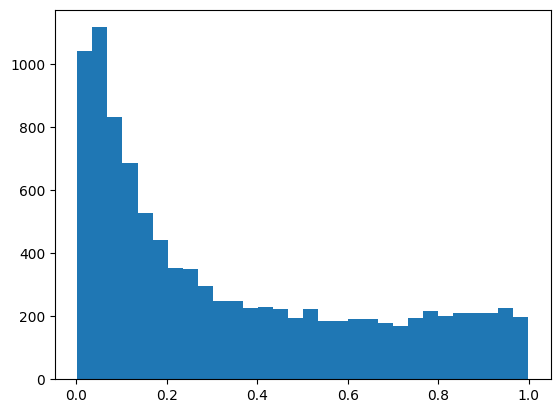

In [44]:
pdl_predict_y = model_cubic_random_mask.predict([np.array(df_test[xvar]),np.array(df_test[tvar])])
df_test['pred_y_dml']=pdl_predict_y.reshape(-1)
plt.hist(pdl_predict_y,bins=30)
plt.show()

In [45]:
#get lambdax

x_train_s = df_test
modelu = Model(inputs=model_cubic_random_mask.input, outputs=model_cubic_random_mask.get_layer('u').output)
dnn_x_test = x_train_s[xvar]
f = x_train_s.groupby(tvar)['Feature_1'].count().reset_index()
sumt = f['Feature_1'].sum()
F_list = f['Feature_1']/sumt

aa2 = np.zeros((len(x_train_s),4,4))

# use binary crossentropy as loss
# for i in range(len(f)):
#     t = f[tvar[0]][i]
#     tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
#     u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
#     for j in range(len(x_train_s)):
#         # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
#         l_pp = (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*np.outer(tildet,tildet)*F_list[i]
#         aa2[j] += l_pp




In [46]:
#use mse as loss
for i in range(len(f)):
    t = f[tvar[0]][i]
    tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
    u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
    for j in range(len(x_train_s)):
        # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
        g_prime =  (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*tildet
        l_pp =np.outer(g_prime,g_prime)*F_list[i]
        aa2[j] += l_pp

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


In [47]:
#lambdax_inv2
cc2=np.zeros((len(x_train_s),4,4))
notinv=[]
for i in range(aa2.shape[0]):
    try:
        cc2[i]=np.linalg.inv(aa2[i]+0.01*np.eye(aa2[0].shape[0]))
        # cc2[i]=np.linalg.pinv(aa2[i])
    except:
        notinv.append(i)
        cc2[i]=np.linalg.inv(aa2[i]+0.005*np.eye(aa2[0].shape[0]))
print('lambda inv done.')
print(len(notinv))

lambda inv done.
0


In [48]:
#get estimators
def g(u):
    return 1/(1+np.exp(-u))
def g_dao(u):
    return np.exp(-u)/((np.exp(-u)+1)**2)
def get_estimates_cubic(model,x_train_s,cc2):
    # Ensure correct shape for inputs
    dnn_x_test = np.array(x_train_s[xvar])

    # dnn_x_test = x_train_s[xvar]
    y0 = model.predict([dnn_x_test, np.array([0]*len(dnn_x_test))])
    u0 = modelu.predict([dnn_x_test, np.array([0]*len(dnn_x_test))])
    n = len(y0)



    #dnn*5
    meanlist=[]
    mselist=[]
    upperlist=[]
    lowerlist=[]
    no_revise_meanlist=[]
    no_revise_mselist=[]
    no_revise_upperlist=[]
    no_revise_lowerlist=[]

    #record result
    resdf = pd.DataFrame()


    prey_real = model.predict([dnn_x_test, np.array(x_train_s[tvar])])
    preu_real = modelu.predict([dnn_x_test, np.array(x_train_s[tvar]).reshape(-1)])
    exp_t_values = [0,0.128,0.388,0.538,0.938]
    for unobs_t in exp_t_values[1:]:
    
        # dnn_t_test = np.array([unobs_t]*len(x_train_s))
        dnn_t_test = np.array([unobs_t] * len(x_train_s)).reshape(-1, len(tvar))
        exp_preu = modelu.predict([dnn_x_test,dnn_t_test.reshape(-1)])
        exp_prey = model.predict([dnn_x_test,dnn_t_test])

        result_df = pd.DataFrame()
        result_df['preu']=np.array(exp_preu).reshape(-1)
        result_df['exp_prey']=exp_prey.reshape(-1)

        result_df['preuu0']=u0.reshape(-1)
        result_df['preyu0']=y0.reshape(-1)
        result_df['dGu0']= g_dao(np.array(result_df['preuu0']))
        result_df['dGu'] = g_dao(np.array(result_df['preu']))
        result_df['Gu0'] = g(np.array(result_df['preuu0']))
        result_df['Gu']  = g(np.array(result_df['preu']))

        result_df['y']=np.array(x_train_s['is_upload']).reshape(-1)

        result_df['prey_real']=prey_real.reshape(-1)
        result_df['preu_real']=preu_real.reshape(-1)
        result_df['dGpreu_real']=g_dao(np.array(result_df['preu_real']))

        # result_df['loss_weight']=result_df['y']*class_weights[1] + (1-result_df['y'])*class_weights[0]
        # result_df['g_y']=(result_df['prey_real']-result_df['y'])*result_df['loss_weight']
        result_df['g_y']=(result_df['prey_real']-result_df['y'])

        result_df['dh1']=result_df['dGu']-result_df['dGu0']
        result_df['dht1']=result_df['dGu']*unobs_t
        result_df['dht2']=result_df['dGu']*unobs_t*unobs_t
        result_df['dht3']=result_df['dGu']*unobs_t*unobs_t*unobs_t


        result_df['l1'] = result_df['g_y']*result_df['dGpreu_real']
        # result_df['l1'] = result_df['g_y']

        result_df['lt1'] = np.array(x_train_s[tvar]).reshape(-1)*np.array(result_df['l1']).reshape(-1)
        result_df['lt2'] = np.array(x_train_s[tvar]).reshape(-1)*np.array(result_df['lt1']).reshape(-1)
        result_df['lt3'] = np.array(x_train_s[tvar]).reshape(-1)*np.array(result_df['lt2']).reshape(-1)

        n=len(result_df)
        array1 = np.array(result_df[['dh1','dht1','dht2','dht3']]) #dH
        array2 = cc2.copy()                        #lambda x inv
        array6 =  np.array(result_df[['l1','lt1','lt2','lt3']]) #dl
        tri_multi = []

        for j in range(n):
            tri_multi.append(np.dot(array1[j].reshape(1,4),np.dot(array2[j],array6[j].reshape(4,1))))


        result_df['tri']=np.array(tri_multi).reshape(-1)
        no_revise_est = result_df['exp_prey'] - result_df['preyu0']
        est = result_df['exp_prey'] - result_df['preyu0'] -  result_df['tri']

        resdf[f'norevise_combo_{unobs_t}'] = no_revise_est
        resdf[f'revise_combo_{unobs_t}'] = est
        resdf[f'tri_{unobs_t}']=result_df['tri']

        print(unobs_t)
        no_revise_mean = no_revise_est.mean()
        no_revise_mse = ((no_revise_est-no_revise_est.mean())**2).mean()
        no_revise_lower = no_revise_mean-1.96*no_revise_mse/np.sqrt(n)
        no_revise_upper = no_revise_mean+1.96*no_revise_mse/np.sqrt(n)
        print("no revise====")
        print(no_revise_mean,no_revise_mse,no_revise_lower,no_revise_upper)
        no_revise_meanlist.append(no_revise_mean)
        no_revise_mselist.append(no_revise_mse)
        no_revise_lowerlist.append(no_revise_lower)
        no_revise_upperlist.append(no_revise_upper)

        mean = est.mean()
        meanlist.append(mean)
        mse = ((est-est.mean())**2).mean()
        mselist.append(mse)
        lower = mean-1.96*mse/np.sqrt(n)
        lowerlist.append(lower)
        upper = mean+1.96*mse/np.sqrt(n)
        upperlist.append(upper)
        print("revise====")
        print(mean,mse,lower,upper)

    sumtable = pd.DataFrame({'combo':[1,2,3,4],'diff':meanlist,'mse':mselist,'upper':upperlist,'lower':lowerlist})
    no_revise_sumtable = pd.DataFrame({'combo':[1,2,3,4],'diff':no_revise_meanlist,'mse':no_revise_mselist,'upper':no_revise_upperlist,'lower':no_revise_lowerlist})
    return sumtable,no_revise_sumtable,resdf

In [49]:
# df4,df5,df6 = get_estimates_cubic(model_cubic_random_mask,df_test,cc2)

In [50]:
# find optimal
#get lambda x inverse: cc2
#get ltheta:
modela = Model(model_cubic_random_mask.input,model_cubic_random_mask.get_layer('parameter_a').output)
modelb = Model(model_cubic_random_mask.input,model_cubic_random_mask.get_layer('parameter_bcd').output)
resdf = pd.DataFrame()
resdf['a'] = modela.predict([df_test[xvar],np.array([0]*len(df_test))]).reshape(-1)
a = np.array(resdf['a'])
b = modelb.predict([df_test[xvar],np.array([0]*len(df_test))])
resdf['b1'] = b[:,0]
resdf['b2'] = b[:,1]
resdf['b3'] = b[:,2]
resdf['prey_real'] = model_cubic_random_mask.predict([df_test[xvar],df_test[tvar]]).reshape(-1)
resdf['preu_real'] = modelu.predict([df_test[xvar],np.array(df_test[tvar]).reshape(-1)]).reshape(-1)

resdf['dGpreu_real']=g_dao(np.array(resdf['preu_real']))

resdf['y'] = df_test['y']
# resdf['loss_weight']=resdf['y']*class_weights[1] + (1-resdf['y'])*class_weights[0]
# resdf['g_y'] =(resdf['prey_real']-resdf['y'])
resdf['g_y'] =(resdf['prey_real']-resdf['y'])
resdf['l1'] = resdf['g_y']*resdf['dGpreu_real']
# resdf['l1'] = resdf['g_y']
resdf['lt1'] = np.array(df_test[tvar]).reshape(-1)*np.array(resdf['l1']).reshape(-1)
resdf['lt2'] = np.array(df_test[tvar]).reshape(-1)*np.array(resdf['lt1']).reshape(-1)
resdf['lt3'] = np.array(df_test[tvar]).reshape(-1)*np.array(resdf['lt2']).reshape(-1)
ltheta = np.array(resdf[['l1','lt1','lt2','lt3']])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


In [51]:
resdf[['a','b1','b2','b3']].mean()

a    -2.075356
b1    3.411398
b2    1.630292
b3    2.094063
dtype: float32

In [52]:
#method1: use discretized t set to find
def g(u):
    return 1 / (1 + np.exp(-u))

def g_dao(u):
    return np.exp(-u) / ((np.exp(-u) + 1) ** 2)

def ufunc1(t, a, b1, b2, b3):
    return a + b1 * t + b2 * t *t + b3 * t *t*t

def gtheta(u, t):
    dgu = g_dao(u)
    res = np.vstack(([dgu], [dgu * t], [dgu * t ** 2], [dgu * t ** 3]))
    res = np.transpose(res)
#     res = res.reshape((len(df_test),1,4))
    return res

def objective(t_set, i, a, b, cc2, ltheta):
    aa = a[i]
    bb1 = b[i, 0]
    bb2 = b[i, 1]
    bb3 = b[i, 2]
    uu = ufunc(t_set, aa, bb1, bb2, bb3)
    gtheta_u = gtheta(uu, t_set)
    gu = g(uu)
    psi_value=[]
    for j in range(len(t_set)):
        tempt = t_set[j]
        psi = gu[j]-np.dot(gtheta_u[j,:].reshape(1,4),np.dot(cc2[i],ltheta[i].reshape(4,1)))
        psi_value.append(psi)

    return np.array(gu).reshape(-1),np.array(psi_value).reshape(-1)

In [53]:
ltheta = ltheta.reshape((len(df_test),4,1))

In [54]:
import numpy as np

def g(u):
    return 1 / (1 + np.exp(-u))

def g_dao(u):
    return np.exp(-u) / ((np.exp(-u) + 1) ** 2)
    # return g(u)*(1-g(u))

def ufunc(t, a, b1, b2, b3):
    return a[:, None] + b1[:, None] * t + b2[:, None] * t**2 + b3[:, None] * t**3

def gtheta(u, t):
    dgu = g_dao(u)
    return np.stack((dgu, dgu * t, dgu * t**2, dgu * t**3), axis=-1)

def objective(t_set, a, b, cc2, ltheta):
    uu = ufunc(t_set, a, b[:, 0], b[:, 1], b[:, 2])
    gu = g(uu)
    gtheta_u = gtheta(uu, t_set)

    # Using broadcasting and tensor dot product
    cc2_dot_ltheta = np.matmul(cc2, ltheta)  # Shape will be (num_samples, 4, 1)
    psi = gu - np.matmul(gtheta_u, cc2_dot_ltheta)[:, :, 0]  # Remove last dimension and align shapes

    return gu, psi.squeeze()
# Define your parameters

# Call the objective function without the loop
gu, psi = objective(t_values, a, b, cc2, ltheta)

psi_array_DLPT = psi  # Transpose to match the expected shape (num_samples, len(t_values))
psi_array_SDL = gu  # Assuming you need the same values here; adjust if necessary
SDL_value_array = psi_array_SDL*(0.5 - author_value*t_values)
DLPT_value_array=psi_array_DLPT*(0.5 - author_value*t_values)
df_test['learned_SDL_policy'] = np.argmax(SDL_value_array,axis=1)
df_test['SDL_est_policy_value'] = np.max(SDL_value_array,axis=1)
df_test['learned_DLPT_policy'] = np.argmax(DLPT_value_array,axis=1)
df_test['DLPT_est_policy_value'] = np.max(DLPT_value_array,axis=1)

In [55]:
df_test['optimal_r'].mean(),df_test['DLPT_est_policy_value'].mean(),df_test['SDL_est_policy_value'].mean()

(0.23557742967928624, 0.26496188240355184, 0.24454200320814048)

In [56]:
cc2 = tf.cast(cc2,tf.float32)
ltheta = tf.cast((ltheta),tf.float32)

In [57]:
## define policy class t=f(v,x),f is a fixed size dnn
from keras.initializers import GlorotUniform,LecunNormal,HeNormal
def DNN_policy_class(xvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    a = layers.Dense(20,activation='relu')(input1_)
    a = layers.Dense(20,activation='relu')(a)
    a = layers.Dense(20,activation='relu')(a)
    output_ = layers.Dense(1)(a)
    model = Model(inputs=[input1_],outputs=[output_])
    model.summary()
    return model
def linear_policy_class(xvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    output_ = layers.Dense(1,kernel_initializer = HeNormal())(input1_)
    model = Model(inputs=[input1_],outputs=[output_])
    model.summary()
    return model   
def custom_loss(t,a ,b,cc2,ltheta):
    uu = ufunc1(t,a,b[:,0],b[:,1],b[:,2])
    gtheta_u = gtheta(uu, t)
    nan_mask = np.isnan(gtheta_u)
    gtheta_u[nan_mask]=0
    gtheta_u = tf.cast(gtheta_u,tf.float32)
    gtheta_u = tf.reshape(gtheta_u, ((len(df_test), 1, 4)))
    gu = g(uu)
    cc2new = tf.matmul(cc2,ltheta)
    debias_term  = tf.matmul(gtheta_u,cc2new)
    debias_term = tf.squeeze(debias_term)
    nan_mask = tf.math.is_nan(debias_term)
    debias_term = tf.where(nan_mask, tf.zeros_like(debias_term), debias_term)
    psi = gu  - debias_term
    sdl_psi = gu
    psi = tf.clip_by_value(psi, 0, 1)
#     value = tf.nn.relu(psi)*tf.nn.relu(0.5-0.1*t)
    value = psi*(0.5-author_value*t)
    sdl_value = sdl_psi*(0.5-author_value*t)
    print(value)
    return -tf.reduce_mean(value), -tf.reduce_mean(sdl_value)
def train_step(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss(predictions,a ,b,cc2,ltheta)[0]
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [58]:
# Instantiate the model
# DLPT_policy = DNN_policy_class(xvar)
DLPT_policy = linear_policy_class(xvar)
DLPT_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
DLPT_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=100,batch_size = 32)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.4490 - mae: 0.5333
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 0.1128 - mae: 0.2644
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 0.0434 - mae: 0.1647
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 0.0309 - mae: 0.1394
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.0253 - mae: 0.1261
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 0.0221 - mae: 0.1166
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 0.0199 - mae: 0.1108
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 0.0179 - mae: 0.1043
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.0165 - mae: 0.1000
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 0.0162 - mae: 0.0986
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 0.0160 - mae: 0.0976
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 0.0159 - m

In [59]:
# Optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# Training parameters
num_epochs = 1000
inputs = np.array(df_test[xvar])

In [60]:
# Training loop
loss_history = []
patience = 10  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step(DLPT_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

# Print the final model parameters
for var in DLPT_policy.trainable_variables:
    print(var.name, var.numpy())


tf.Tensor([0.2688476  0.29919392 0.27068043 ... 0.2722871  0.26433632 0.19502743], shape=(10000,), dtype=float32)
Epoch 0: Loss: -0.24074433743953705


tf.Tensor([0.2688254  0.2991358  0.27068478 ... 0.27226898 0.2642399  0.19505823], shape=(10000,), dtype=float32)
Epoch 1: Loss: -0.2407342791557312
Loss increased! Trigger times: 1/10
tf.Tensor([0.2688031  0.29907763 0.27068913 ... 0.27225086 0.26414335 0.195089  ], shape=(10000,), dtype=float32)
Epoch 2: Loss: -0.24072422087192535
Loss increased! Trigger times: 2/10
tf.Tensor([0.2687807  0.29901943 0.27069348 ... 0.2722327  0.2640467  0.19511971], shape=(10000,), dtype=float32)
Epoch 3: Loss: -0.24071413278579712
Loss increased! Trigger times: 3/10
tf.Tensor([0.2687582  0.29896122 0.27069777 ... 0.2722145  0.2639499  0.19515038], shape=(10000,), dtype=float32)
Epoch 4: Loss: -0.2407039850950241
Loss increased! Trigger times: 4/10
tf.Tensor([0.26873565 0.29890296 0.270702   ... 0.2721963  0.263853   0.19518097], shape=(10000,), dtype=float32)
Epoch 5: Loss: -0.2406938225030899
Loss increased! Trigger times: 5/10
tf.Tensor([0.26871303 0.29884464 0.27070624 ... 0.27217802 0.26375604 0.1

In [61]:
DLPT_policy2 = DNN_policy_class(xvar)
DLPT_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
DLPT_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=100,batch_size = 32)
# Training loop
loss_history = []
patience = 1  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
for epoch in range(num_epochs):
    loss = train_step(DLPT_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.1215 - mae: 0.2725
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0225 - mae: 0.1175
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 0.0177 - mae: 0.1033
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 0.0159 - mae: 0.0967
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0142 - mae: 0.0916
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0139 - mae: 0.0890
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0134 - mae: 0.0882
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0134 - mae: 0.0880
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0127 - mae: 0.0854
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.0127 - mae: 0.0846
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.0116 - mae: 0.0821
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0111 - m

In [62]:
#same for SDL
#within same policy class
# SDL_policy = DNN_policy_class(xvar)
SDL_policy =linear_policy_class(xvar)
SDL_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
SDL_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_SDL_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
def train_step_sdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss(predictions,a ,b,cc2,ltheta)[1]
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_sdl(SDL_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.8376 - mae: 0.7371
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.4202 - mae: 0.5181
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.2860 - mae: 0.4278
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.1914 - mae: 0.3511
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.1301 - mae: 0.2880
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0882 - mae: 0.2370
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.0653 - mae: 0.2042
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.0496 - mae: 0.1785
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.0413 - mae: 0.1616
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.0347 - mae: 0.1486
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0314 - mae: 0.1411
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.0283 - mae: 0.1338
Epoch 13/20
79/79 ━━━━━━━

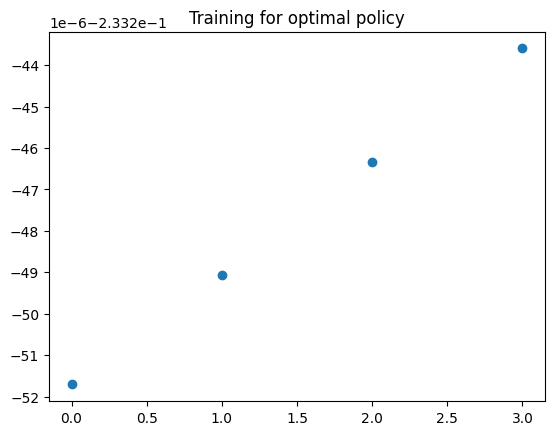

In [63]:
plt.scatter(np.arange(len(loss_history)),np.array(loss_history))
plt.title('Training for optimal policy')
plt.show()

In [64]:
SDL_policy2 = DNN_policy_class(xvar)
SDL_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
SDL_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_SDL_policy']))],epochs=50,batch_size = 32)
# Training loop
num_epochs = 200
inputs = np.array(df_test[xvar])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_sdl(SDL_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.1662 - mae: 0.3081
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0297 - mae: 0.1365
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0159 - mae: 0.0988
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0107 - mae: 0.0799
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 0.0077 - mae: 0.0679
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0061 - mae: 0.0596
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0054 - mae: 0.0555
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 0.0050 - mae: 0.0534
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0045 - mae: 0.0506
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0042 - mae: 0.0483
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0040 - mae: 0.0465
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.0036 - mae: 0.0442
E

In [65]:
SDL_policy_class = tf.squeeze(SDL_policy(inputs))

In [66]:
SDL_policy_class

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([0.711264  , 0.36289862, 0.5436734 , ..., 0.61572635, 0.6406292 ,
       1.0568385 ], dtype=float32)>

## LR

coef of treatment: 0.00000000
coef of treatment: 0.08827122
coef of treatment: 0.26757212
coef of treatment: 0.37101495
coef of treatment: 0.64686250


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 1.1360 - mae: 0.8983
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.3680 - mae: 0.4855
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.2463 - mae: 0.3987
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.1843 - mae: 0.3447
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.1363 - mae: 0.2975
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.1069 - mae: 0.2635
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.0857 - mae: 0.2360
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.0677 - mae: 0.2097
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.0571 - mae: 0.1932
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.0481 - mae: 0.1765
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.0410 - mae: 0.1631
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.0359 - mae: 0.1527
Epoch 13/20
79/79 ━━━━━━━

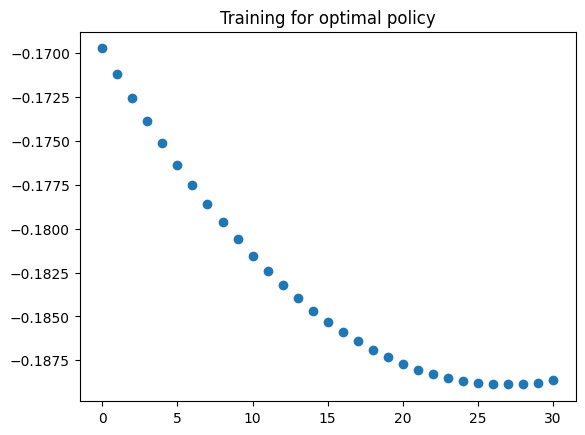

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 0.1952 - mae: 0.3589 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.0583 - mae: 0.1952
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.0381 - mae: 0.1564
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.0298 - mae: 0.1367
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 0.0255 - mae: 0.1266
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.0229 - mae: 0.1186
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0204 - mae: 0.1115
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0190 - mae: 0.1082
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.0180 - mae: 0.1042
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.0168 - mae: 0.1007
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.0157 - mae: 0.0971
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0148 - mae: 0.0942
Epoch 13/20
79/79 ━━━━━━

In [67]:

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')
reg = LinearRegression(fit_intercept=True).fit(np.array(df_train[xvar+tvar]),np.array(df_train['is_upload']))
#predicted ate:

df_test['tempt'] = 0
base = reg.predict(np.array(df_test[xvar+['tempt']]))
exp_t_values = [0,0.128,0.388,0.538,0.938]
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = reg.predict(df_test[xvar+['tempt']])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))
LR_outcome_array=np.zeros((len(df_test),len(t_values)))
for i in range(len(t_values)):
    df_test['tempt']=t_values[i]
    LR_outcome_array[:,i] = reg.predict(df_test[xvar+['tempt']])
LR_value_array = LR_outcome_array*(0.5-author_value*t)
df_test['learned_LR_policy'] = np.argmax(LR_value_array,axis=1)
df_test['LR_est_policy_value'] = np.max(LR_value_array,axis=1)
#within same policy class
# LR_policy = DNN_policy_class(xvar)
LR_policy = linear_policy_class(xvar)
LR_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LR_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_LR_policy']))],epochs=20,batch_size = 128)
def custom_loss_lr(t,reg,df_test):
    df_test['tempt']=t
    psi = reg.predict(df_test[xvar+['tempt']])
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_lr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_lr(predictions,reg,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_lr(LR_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

# Print the final model parameters

for var in LR_policy.trainable_variables:
    print(var.name, var.numpy())
plt.scatter(np.arange(len(loss_history)),np.array(loss_history))
plt.title('Training for optimal policy')
plt.show()
LR_policy_class = tf.squeeze(LR_policy(inputs))


LR_policy2 = DNN_policy_class(xvar)
LR_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LR_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)
def custom_loss_lr(t,reg,df_test):
    df_test['tempt']=t
    psi = reg.predict(df_test[xvar+['tempt']])
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_lr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_lr(predictions,reg,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_lr(LR_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

## LogR

In [68]:
# LogR
def logistic(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')


    inputall = layers.concatenate([input1_,input2_])
    a = layers.Dense(1,name='output',activation='sigmoid')(inputall)

    model = Model(inputs=[input1_,input2_],outputs=[a])
    model.summary()
    return model
model_logistic = logistic(xvar,tvar)
loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model_logistic.compile(optimizer = opt,loss = loss,metrics=METRICS)
history = model_logistic.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=100,batch_size = 128,validation_split=0.1)
#predicted ate:

df_test['tempt'] = 0
base = model_logistic.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = model_logistic.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))
import numpy as np

LogR_policy = linear_policy_class(xvar)
LogR_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LogR_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)
def custom_loss_logr(t,model_logistic,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_logistic([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_logr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_logr(predictions,model_logistic,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_logr(LogR_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0
LogR_policy_class = tf.squeeze(LogR_policy(inputs))

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 71)        │          0 │ feature_input[0]… │
│ (Concatenate)       │                   │            │ treatment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         72 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72 (288.00 B)

 Trainable params: 72 (288.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7263 - auc: 0.7676 - fn: 1006.2917 - fp: 518.5278 - loss: 0.5740 - prc: 0.6266 - precision: 0.6253 - recall: 0.4627 - tn: 3231.9443 - tp: 911.0139 - val_accuracy: 0.7700 - val_auc: 0.8320 - val_fn: 140.0000 - val_fp: 90.0000 - val_loss: 0.4667 - val_prc: 0.6849 - val_precision: 0.6691 - val_recall: 0.5652 - val_tn: 588.0000 - val_tp: 182.0000
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7670 - auc: 0.8286 - fn: 642.2361 - fp: 438.2222 - loss: 0.4762 - prc: 0.7289 - precision: 0.6863 - recall: 0.6090 - tn: 2617.0139 - tp: 970.3055 - val_accuracy: 0.7990 - val_auc: 0.8439 - val_fn: 110.0000 - val_fp: 91.0000 - val_loss: 0.4529 - val_prc: 0.7114 - val_precision: 0.6997 - val_recall: 0.6584 - val_tn: 587.0000 - val_tp: 212.0000
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.7861 - auc: 0.8439 - fn: 599.0000 - fp: 413.3889 - loss: 0.4587 - prc: 0.7391 - precision: 0.7114 - recall: 0.63

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1.2653 - mae: 0.9422
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.4424 - mae: 0.5335
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.2899 - mae: 0.4327
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.2163 - mae: 0.3732
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.1679 - mae: 0.3302
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.1291 - mae: 0.2895
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.1010 - mae: 0.2552
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0818 - mae: 0.2294
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.0690 - mae: 0.2107
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.0585 - mae: 0.1940
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.0505 - mae: 0.1801
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.0445 - mae: 0.1684
Epoch 13/20
79/79 ━━━━━━━

In [69]:
LogR_policy2 = DNN_policy_class(xvar)
LogR_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LogR_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)
def custom_loss_logr(t,model_logistic,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_logistic([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_logr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_logr(predictions,model_logistic,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_logr(LogR_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.1991 - mae: 0.3646 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.0521 - mae: 0.1842
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.0337 - mae: 0.1468
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 0.0269 - mae: 0.1297
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.0233 - mae: 0.1204
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.0210 - mae: 0.1137
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.0191 - mae: 0.1069
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0184 - mae: 0.1054
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.0167 - mae: 0.1001
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0154 - mae: 0.0957
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0144 - mae: 0.0930
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.0139 - mae: 0.0901
Epoch 13/20
79/79 ━━━━━━

## LCM

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 1)         │         70 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 1)         │         70 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u (Add)             │ (None, 1)         │          0 │ dense_37[0][0],   │
│                     │                   │            │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │          2 │ u[0][0]           │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 142 (568.00 B)

 Trainable params: 142 (568.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6732 - auc: 0.6559 - fn: 1541.4700 - fp: 305.7668 - loss: 0.6516 - prc: 0.5052 - precision: 0.5463 - recall: 0.2191 - tn: 3341.6819 - tp: 354.7986 - val_accuracy: 0.7000 - val_auc: 0.6943 - val_fn: 277.0000 - val_fp: 23.0000 - val_loss: 0.5847 - val_prc: 0.5115 - val_precision: 0.6618 - val_recall: 0.1398 - val_tn: 655.0000 - val_tp: 45.0000
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.6902 - auc: 0.7257 - fn: 1198.6326 - fp: 174.3640 - loss: 0.5845 - prc: 0.5841 - precision: 0.6893 - recall: 0.2213 - tn: 2801.6255 - tp: 369.0954 - val_accuracy: 0.7450 - val_auc: 0.7715 - val_fn: 202.0000 - val_fp: 53.0000 - val_loss: 0.5384 - val_prc: 0.6155 - val_precision: 0.6936 - val_recall: 0.3727 - val_tn: 625.0000 - val_tp: 120.0000
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.7383 - auc: 0.7807 - fn: 898.0176 - fp: 280.1237 - loss: 0.5382 - prc: 0.6460 - precision: 0.6977 - recall

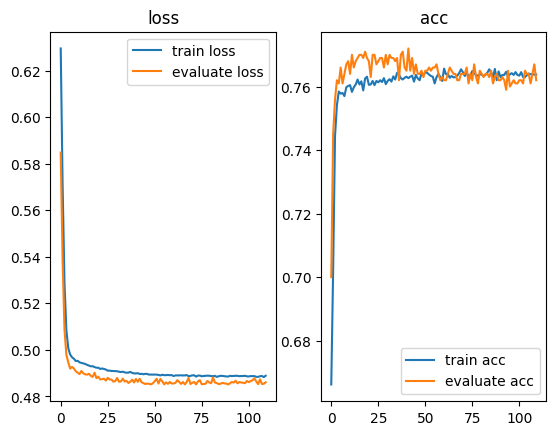

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
coef of treatment: 0.00000000


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.5491 - mae: 0.5953
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.3004 - mae: 0.4403
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.1895 - mae: 0.3521
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.1291 - mae: 0.2897
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 0.0887 - mae: 0.2381
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0647 - mae: 0.2032
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.0513 - mae: 0.1809
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0434 - mae: 0.1666
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.0371 - mae: 0.1527
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.0340 - mae: 0.1466
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.0318 - mae: 0.1409
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.0295 - mae: 0.1361
Epoch 13/20
79/79 ━━━━━━━

In [70]:

def lcm(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')
    
    a = layers.Dense(1,use_bias = False)(input1_)
    b = layers.Dense(1,use_bias = False)(input1_)
    def custom_multiply_and_sum(inputs):
        parab, t = inputs
        return tf.reduce_sum(parab * t, axis=-1, keepdims=True) 

    bt = tf.keras.layers.Lambda(custom_multiply_and_sum)([b, t])
    abt = layers.Add(name='u')([a,bt])
    # abcdt = layers.Add(name='u')([paraa,bbt])
    u = layers.Dense(1,name='output',activation='sigmoid')(abt)

    model = Model(inputs=[input1_,input2_],outputs=[u])
    model.summary()
    return model

model_lcm = lcm(xvar,tvar)
loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lcm.compile(optimizer = opt,loss = loss,metrics=METRICS)
history = model_lcm.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=200,batch_size = 32,validation_split=0.1,callbacks=[early_stopping])
loss = history.history['loss']  # 测试集损失
acc = history.history['accuracy']  # 测试集准确率
val_loss = history.history['val_loss']  # 验证集损失
val_acc = history.history['val_accuracy']  # 验证集准确率|
plt.figure()
plt.subplot(121)
plt.plot(loss,label='train loss')
plt.plot(val_loss,label = 'evaluate loss')
plt.legend()
plt.title('loss')
plt.subplot(122)
plt.plot(acc,label='train acc')
plt.plot(val_acc,label = 'evaluate acc')
plt.legend()
plt.title('acc')
plt.show()


#predicted ate:
df_test['tempt'] = 0
base = model_lcm.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = model_lcm.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))


LCM_policy = linear_policy_class(xvar)
LCM_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LCM_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_lcm,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(LCM_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0
LCM_policy_class = tf.squeeze(LCM_policy(inputs))

In [71]:
LCM_policy2 = linear_policy_class(xvar)
LCM_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LCM_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_lcm,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(LCM_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.7537 - mae: 0.6998 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.3922 - mae: 0.4999
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 0.2887 - mae: 0.4301
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.2091 - mae: 0.3656
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.1496 - mae: 0.3127
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.1094 - mae: 0.2652
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.0825 - mae: 0.2304
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0649 - mae: 0.2036
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0522 - mae: 0.1832
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.0438 - mae: 0.1673
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.0394 - mae: 0.1586
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.0355 - mae: 0.1499
Epoch 13/20
79/79 ━━━━━━

## PDL

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 71)        │          0 │ feature_input[0]… │
│ (Concatenate)       │                   │            │ treatment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 10)        │        720 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 10)        │        110 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 10)        │        110 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         11 │ dense_43[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 951 (3.71 KB)

 Trainable params: 951 (3.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6600 - auc: 0.6268 - fn: 1573.7208 - fp: 344.4417 - loss: 0.6654 - prc: 0.4672 - precision: 0.4850 - recall: 0.2033 - tn: 3313.7385 - tp: 311.8163 - val_accuracy: 0.6700 - val_auc: 0.5696 - val_fn: 313.0000 - val_fp: 17.0000 - val_loss: 0.6387 - val_prc: 0.3922 - val_precision: 0.3462 - val_recall: 0.0280 - val_tn: 661.0000 - val_tp: 9.0000
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.6546 - auc: 0.5722 - fn: 1528.1626 - fp: 45.1307 - loss: 0.6430 - prc: 0.3996 - precision: 0.4436 - recall: 0.0242 - tn: 2935.1130 - tp: 35.3110 - val_accuracy: 0.6800 - val_auc: 0.5927 - val_fn: 316.0000 - val_fp: 4.0000 - val_loss: 0.6238 - val_prc: 0.4120 - val_precision: 0.6000 - val_recall: 0.0186 - val_tn: 674.0000 - val_tp: 6.0000
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.6544 - auc: 0.5807 - fn: 1552.6855 - fp: 18.0530 - loss: 0.6364 - prc: 0.4023 - precision: 0.4400 - recall: 0.01

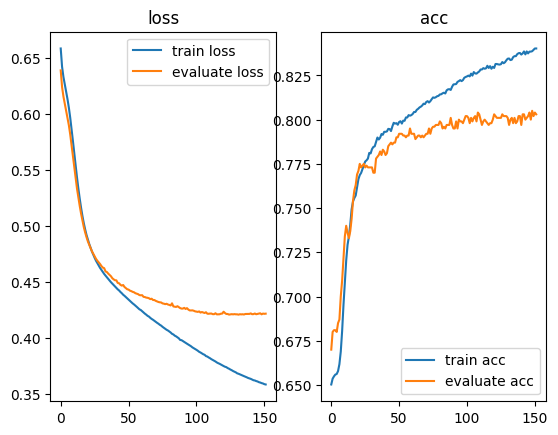

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
coef of treatment: 0.06866629
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
coef of treatment: 0.24079712
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
coef of treatment: 0.34807086
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
coef of treatment: 0.59223312


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 1.1168 - mae: 0.8799 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.4282 - mae: 0.5235
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.2949 - mae: 0.4345
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.2242 - mae: 0.3770
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 0.1702 - mae: 0.3297
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.1288 - mae: 0.2858
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.1033 - mae: 0.2558
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 0.0815 - mae: 0.2274
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.0666 - mae: 0.2059
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0563 - mae: 0.1885
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.0490 - mae: 0.1757
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.0437 - mae: 0.1652
Epoch 13/20
79/79 ━━━━━━

In [72]:
# PDL
def pdl(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')

#     initializer = tf.keras.initializers.GlorotUniform()
    inputall = layers.concatenate([input1_,input2_])
    a = layers.Dense(10,activation='relu')(inputall)
    a = layers.Dense(10,activation='relu')(a)
    a = layers.Dense(10,activation='relu')(a)
    a = layers.Dense(1,name='output',activation='sigmoid')(a)

    model = Model(inputs=[input1_,input2_],outputs=[a])
    model.summary()
    return model
model_pdl = pdl(xvar,tvar)
loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_pdl.compile(optimizer = opt,loss = loss,metrics=METRICS)
history = model_pdl.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=200,batch_size = 32,validation_split=0.1,callbacks=[early_stopping])
loss = history.history['loss']  # 测试集损失
acc = history.history['accuracy']  # 测试集准确率
val_loss = history.history['val_loss']  # 验证集损失
val_acc = history.history['val_accuracy']  # 验证集准确率|
plt.figure()
plt.subplot(121)
plt.plot(loss,label='train loss')
plt.plot(val_loss,label = 'evaluate loss')
plt.legend()
plt.title('loss')
plt.subplot(122)
plt.plot(acc,label='train acc')
plt.plot(val_acc,label = 'evaluate acc')
plt.legend()
plt.title('acc')
plt.show()


#predicted ate:
df_test['tempt'] = 0
base = model_pdl.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = model_pdl.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))
# PDL_outcome_array = np.zeros((len(df_test),len(t_values)))
# for i in range(len(t_values)):
#     df_test['tempt']=t_values[i]
#     PDL_outcome_array[:,i]=model_pdl.predict([df_test[xvar],df_test['tempt']]).reshape(-1)
# PDL_outcome_array = model_pdl.predict(combined_input).reshape(len(t_values), len(df_test)).T
# PDL_value_array = PDL_outcome_array*(0.5 - author_value*t_values)
# df_test['learned_PDL_policy'] = np.argmax(PDL_value_array,axis=1)
# df_test['PDL_est_policy_value'] = np.max(PDL_value_array,axis=1)
# print(df_test['PDL_est_policy_value'].mean())
#within same policy class
# PDL_policy = DNN_policy_class(xvar)
PDL_policy = linear_policy_class(xvar)
PDL_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
PDL_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_pdl,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(PDL_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0
PDL_policy_class = tf.squeeze(PDL_policy(inputs))

In [73]:
PDL_policy2 = linear_policy_class(xvar)
PDL_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
PDL_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_pdl,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(PDL_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 0.6676 - mae: 0.6694 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.2630 - mae: 0.4090
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.1810 - mae: 0.3403
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.1316 - mae: 0.2912
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0950 - mae: 0.2473
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.0734 - mae: 0.2176
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0585 - mae: 0.1936
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.0494 - mae: 0.1779
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.0436 - mae: 0.1666
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 0.0388 - mae: 0.1573
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.0364 - mae: 0.1517
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0346 - mae: 0.1477
Epoch 13/20
79/79 ━━━━━━

## AVG

In [74]:
AVG_outcome_array = np.array(df_train.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
obs_tvalues = np.array(df_train.groupby('t')['is_upload'].mean().reset_index()['t'])
AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
df_test['learned_AVG_policy'] = np.argmax(AVG_value_array)

In [75]:
AVG_value_array

array([0.09159537, 0.11511279, 0.14665421, 0.1550605 , 0.18476027])

## GROUP

In [76]:
df_test['learned_rightGROUP_policy'] = 0
for i in range(df_train['right_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['right_groupidx']==i]
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_test.loc[df_test['right_groupidx']==i,'learned_rightGROUP_policy']=np.argmax(AVG_value_array)

In [77]:
# df_test['learned_wrongGROUP_policy'] = 0
for i in range(df_train['wrong_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['wrong_groupidx']==i]
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_test.loc[df_test['wrong_groupidx']==i,'learned_wrongGROUP_policy']=np.argmax(AVG_value_array)

## OOS RESULT

### Linear Policy Class

In [78]:
# OOS RESULT
oos_DLPT = tf.clip_by_value(tf.squeeze(DLPT_policy(x_validation)),0,1)
df_val['learned_DLPT_Class_policy']=oos_DLPT
oos_SDL = tf.clip_by_value(tf.squeeze(SDL_policy(x_validation)),0,1)
oos_LR = tf.clip_by_value(tf.squeeze(LR_policy(x_validation)),0,1)
oos_LogR = tf.clip_by_value(tf.squeeze(LogR_policy(x_validation)),0,1)
oos_LCM = tf.clip_by_value(tf.squeeze(LCM_policy(x_validation)),0,1)
oos_PDL = tf.clip_by_value(tf.squeeze(PDL_policy(x_validation)),0,1)
df_val['learned_AVG_policy']=np.argmax(AVG_value_array)
df_val['learned_rightGROUP_policy'] = 0
for i in range(df_train['right_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['right_groupidx']==i]
    a = df_train_group[f'Feature_{C+1}'].mean()
    b = df_train_group[f'Feature_{C+2}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+1}']==a)&(df_val[f'Feature_{C+2}']==b),'learned_rightGROUP_policy']=np.argmax(AVG_value_array)

df_val['learned_wrongGROUP_policy'] = 0
for i in range(df_train['wrong_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['wrong_groupidx']==i]
    a = df_train_group[f'Feature_{C+3}'].mean()
    b = df_train_group[f'Feature_{C+4}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+3}']==a)&(df_val[f'Feature_{C+4}']==b),'learned_wrongGROUP_policy']=np.argmax(AVG_value_array)

df_val['DLPT_Class_true_policy_value']=r(np.array(oos_DLPT),alpha_val,beta_val,theta_val,gamma_val)
df_val['SDL_Class_true_policy_value']=r(np.array(oos_SDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['LR_Class_true_policy_value']=r(np.array(oos_LR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LogR_Class_true_policy_value']=r(np.array(oos_LogR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LCM_Class_true_policy_value']=r(np.array(oos_LCM),alpha_val,beta_val,theta_val,gamma_val)
df_val['PDL_Class_true_policy_value']=r(np.array(oos_PDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['AVG_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_AVG_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['wrongGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_wrongGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['rightGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_rightGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)

print('true optimal policy value:',df_val['optimal_r'].sum())
print('LogR policy value: ',df_val['LogR_Class_true_policy_value'].sum())
print('SDL policy value: ',df_val['SDL_Class_true_policy_value'].sum())
print('DLPT policy value: ',df_val['DLPT_Class_true_policy_value'].sum())
print('LR policy value: ',df_val['LR_Class_true_policy_value'].sum())
print('AVG policy value: ',df_val['AVG_true_policy_value'].sum())
print('wrong GROUP policy value: ',df_val['wrongGROUP_true_policy_value'].sum())
print('right GROUP policy value: ',df_val['rightGROUP_true_policy_value'].sum())
print('LCM policy value: ',df_val['LCM_Class_true_policy_value'].sum())
print('PDL policy value: ',df_val['PDL_Class_true_policy_value'].sum())


true optimal policy value: 466.8429150315774
LogR policy value:  408.49506
SDL policy value:  415.7657
DLPT policy value:  417.56882
LR policy value:  390.05826
AVG policy value:  365.7342736662491
wrong GROUP policy value:  365.7342736662491
right GROUP policy value:  365.7342736662491
LCM policy value:  254.98537
PDL policy value:  408.63345


### DNN Policy Class

In [79]:
# OOS RESULT
oos_DLPT = tf.clip_by_value(tf.squeeze(DLPT_policy2(x_validation)),0,1)
df_val['learned_DLPT_Class_policy']=oos_DLPT
oos_SDL = tf.clip_by_value(tf.squeeze(SDL_policy2(x_validation)),0,1)
oos_LR = tf.clip_by_value(tf.squeeze(LR_policy2(x_validation)),0,1)
oos_LogR = tf.clip_by_value(tf.squeeze(LogR_policy2(x_validation)),0,1)
oos_LCM = tf.clip_by_value(tf.squeeze(LCM_policy2(x_validation)),0,1)
oos_PDL = tf.clip_by_value(tf.squeeze(PDL_policy2(x_validation)),0,1)
df_val['learned_AVG_policy']=np.argmax(AVG_value_array)
df_val['learned_rightGROUP_policy'] = 0
for i in range(df_train['right_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['right_groupidx']==i]
    a = df_train_group[f'Feature_{C+1}'].mean()
    b = df_train_group[f'Feature_{C+2}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+1}']==a)&(df_val[f'Feature_{C+2}']==b),'learned_rightGROUP_policy']=np.argmax(AVG_value_array)

df_val['learned_wrongGROUP_policy'] = 0
for i in range(df_train['wrong_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['wrong_groupidx']==i]
    a = df_train_group[f'Feature_{C+3}'].mean()
    b = df_train_group[f'Feature_{C+4}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+3}']==a)&(df_val[f'Feature_{C+4}']==b),'learned_wrongGROUP_policy']=np.argmax(AVG_value_array)


df_val['DLPT_Class_true_policy_value']=r(np.array(oos_DLPT),alpha_val,beta_val,theta_val,gamma_val)
df_val['SDL_Class_true_policy_value']=r(np.array(oos_SDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['LR_Class_true_policy_value']=r(np.array(oos_LR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LogR_Class_true_policy_value']=r(np.array(oos_LogR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LCM_Class_true_policy_value']=r(np.array(oos_LCM),alpha_val,beta_val,theta_val,gamma_val)
df_val['PDL_Class_true_policy_value']=r(np.array(oos_PDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['AVG_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_AVG_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['wrongGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_wrongGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['rightGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_rightGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)


print('true optimal policy value:',df_val['optimal_r'].sum())
print('LogR policy value: ',df_val['LogR_Class_true_policy_value'].sum())
print('SDL policy value: ',df_val['SDL_Class_true_policy_value'].sum())
print('DLPT policy value: ',df_val['DLPT_Class_true_policy_value'].sum())
print('LR policy value: ',df_val['LR_Class_true_policy_value'].sum())
print('AVG policy value: ',df_val['AVG_true_policy_value'].sum())
print('wrong GROUP policy value: ',df_val['wrongGROUP_true_policy_value'].sum())
print('right GROUP policy value: ',df_val['rightGROUP_true_policy_value'].sum())
print('LCM policy value: ',df_val['LCM_Class_true_policy_value'].sum())
print('PDL policy value: ',df_val['PDL_Class_true_policy_value'].sum())


true optimal policy value: 466.8429150315774
LogR policy value:  372.58932
SDL policy value:  419.026
DLPT policy value:  421.7513
LR policy value:  419.91458
AVG policy value:  365.7342736662491
wrong GROUP policy value:  365.7342736662491
right GROUP policy value:  365.7342736662491
LCM policy value:  254.88902
PDL policy value:  411.50037


### Discretized Continuous Policy Class

In [84]:
#DLPT and SDL
x_train_s = df_val
modelu = Model(inputs=model_cubic_random_mask.input, outputs=model_cubic_random_mask.get_layer('u').output)
dnn_x_test = x_train_s[xvar]
f = x_train_s.groupby(tvar)['Feature_1'].count().reset_index()
sumt = f['Feature_1'].sum()
F_list = f['Feature_1']/sumt

aa2 = np.zeros((len(x_train_s),4,4))
# #use mse as loss
# for i in range(len(f)):
#     t = f[tvar[0]][i]
#     tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
#     u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
#     for j in range(len(x_train_s)):
#         # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
#         g_prime =  (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*tildet
#         l_pp =np.outer(g_prime,g_prime)*F_list[i]
#         aa2[j] += l_pp

#use binary crossentropy as loss
for i in range(len(f)):
    t = f[tvar[0]][i]
    tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
    u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
    for j in range(len(x_train_s)):
        # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
        l_pp = (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*np.outer(tildet,tildet)*F_list[i]
        aa2[j] += l_pp
        
cc2=np.zeros((len(x_train_s),4,4))
notinv=[]
for i in range(aa2.shape[0]):
    try:
        cc2[i]=np.linalg.inv(aa2[i]+0.01*np.eye(aa2[0].shape[0]))
    except:
        notinv.append(i)
        cc2[i]=np.linalg.inv(aa2[i]+0.005*np.eye(aa2[0].shape[0]))
# print('lambda inv done.')
# print(len(notinv))

modela = Model(model_cubic_random_mask.input, model_cubic_random_mask.get_layer('parameter_a').output)
modelb = Model(model_cubic_random_mask.input, model_cubic_random_mask.get_layer('parameter_bcd').output)

resdf = pd.DataFrame()
resdf['a'] = modela.predict([df_val[xvar], np.array([0]*len(df_val))]).reshape(-1)
a = np.array(resdf['a'])
b = modelb.predict([df_val[xvar], np.array([0]*len(df_val))])
resdf['b1'] = b[:,0]
resdf['b2'] = b[:,1]
resdf['b3'] = b[:,2]
resdf['prey_real'] = model_cubic_random_mask.predict([df_val[xvar], np.array([0]*len(df_val))]).reshape(-1)
resdf['preu_real'] = modelu.predict([df_val[xvar], np.array([0]*len(df_val))]).reshape(-1)

resdf['dGpreu_real'] = g_dao(np.array(resdf['preu_real']))

resdf['y'] = df_val['y']
# resdf['loss_weight'] = resdf['y']*class_weights[1] + (1-resdf['y'])*class_weights[0]
# resdf['g_y'] = (resdf['prey_real']-resdf['y'])
resdf['g_y'] = (resdf['prey_real']-resdf['y'])
# resdf['l1'] = resdf['g_y']*resdf['dGpreu_real']
resdf['l1'] = resdf['g_y']
resdf['lt1'] = np.array(df_val[tvar]).reshape(-1)*np.array(resdf['l1']).reshape(-1)
resdf['lt2'] = np.array(df_val[tvar]).reshape(-1)*np.array(resdf['lt1']).reshape(-1)
resdf['lt3'] = np.array(df_val[tvar]).reshape(-1)*np.array(resdf['lt2']).reshape(-1)
ltheta = np.array(resdf[['l1', 'lt1', 'lt2', 'lt3']])
ltheta = ltheta.reshape((len(df_val),4,1))

gu, psi = objective(t_values, a, b, cc2, ltheta)
psi_array_DLPT = psi  # Transpose to match the expected shape (num_samples, len(t_values))
psi_array_SDL = gu  # Assuming you need the same values here; adjust if necessary
SDL_value_array = psi_array_SDL*(0.5 - author_value*t_values)
DLPT_value_array=psi_array_DLPT*(0.5 - author_value*t_values)
df_val['learned_SDL_policy'] = np.argmax(SDL_value_array,axis=1)
df_val['learned_DLPT_policy'] = np.argmax(DLPT_value_array,axis=1)

# print('SDL and DLPT done.')

# LR
LR_outcome_array = np.zeros((len(df_val), len(t_values)))
for i in range(len(t_values)):
    df_val['tempt'] = t_values[i]
    LR_outcome_array[:, i] = reg.predict(df_val[xvar + ['tempt']])
LR_value_array = LR_outcome_array*(0.5 - author_value*t_values)
df_val['learned_LR_policy'] = np.argmax(LR_value_array, axis=1)
# print('LR done.')

def predict_in_batches(model, batch_size=10):
    outcome_array = []
    # Iterate over batches
    batch_size = 500
    for start in range(0, len(df_val), batch_size):
        end = start + batch_size
        tvalues_repeated = np.repeat(t_values, batch_size)
        df_val_repeated = np.tile(np.array(df_val[xvar])[start:end,:], (len(t_values), 1))
        combined_input = [df_val_repeated, tvalues_repeated]
        # Predict for the current batch
        batch_predictions = model.predict(combined_input).reshape(-1)
        outcome_array.append(batch_predictions)
    return np.vstack(outcome_array)


# LogR
LogR_outcome_array = predict_in_batches(model_logistic).reshape(len(t_values), len(df_val)).T
LogR_value_array = LogR_outcome_array*(0.5 - author_value*t_values)
df_val['learned_LogR_policy'] = np.argmax(LogR_value_array, axis=1)
# print('LogR done.')

#LCM
LCM_outcome_array = predict_in_batches(model_lcm).reshape(len(t_values), len(df_val)).T
LCM_value_array = LCM_outcome_array * (0.5 - author_value * np.array(t_values))
df_val['learned_LCM_policy'] = np.argmax(LCM_value_array, axis=1)
# print('LCM done.')

# PDL
PDL_outcome_array = predict_in_batches(model_pdl).reshape(len(t_values), len(df_val)).T
PDL_value_array = PDL_outcome_array*(0.5 - author_value*t_values)
df_val['learned_PDL_policy'] = np.argmax(PDL_value_array, axis=1)
# print('PDL done.')

df_val['LR_true_policy_value'] = r(t_values[list(np.array(df_val['learned_LR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LogR_true_policy_value'] = r(t_values[list(np.array(df_val['learned_LogR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LCM_true_policy_value'] = r(t_values[list(np.array(df_val['learned_LCM_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['PDL_true_policy_value'] = r(t_values[list(np.array(df_val['learned_PDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['SDL_true_policy_value'] = r(t_values[list(np.array(df_val['learned_SDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['DLPT_true_policy_value'] = r(t_values[list(np.array(df_val['learned_DLPT_policy']))], alpha_val, beta_val, theta_val, gamma_val)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 279us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 286us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 254us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 5s 296us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 271us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 265us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 263us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 262us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 271us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 269us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 270us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 279us/step


In [85]:

print('true optimal policy value:',df_val['optimal_r'].sum())
print('LogR policy value: ',df_val['LogR_true_policy_value'].sum())
print('SDL policy value: ',df_val['SDL_true_policy_value'].sum())
print('DLPT policy value: ',df_val['DLPT_true_policy_value'].sum())
print('LR policy value: ',df_val['LR_true_policy_value'].sum())
print('AVG policy value: ',df_val['AVG_true_policy_value'].sum())
print('wrong GROUP policy value: ',df_val['wrongGROUP_true_policy_value'].sum())
print('right GROUP policy value: ',df_val['rightGROUP_true_policy_value'].sum())
print('LCM policy value: ',df_val['LCM_true_policy_value'].sum())
print('PDL policy value: ',df_val['PDL_true_policy_value'].sum())

true optimal policy value: 466.8429150315774
LogR policy value:  310.53175097959286
SDL policy value:  417.81351029343784
DLPT policy value:  434.90009411379
LR policy value:  420.6309883287438
AVG policy value:  365.7342736662491
wrong GROUP policy value:  365.7342736662491
right GROUP policy value:  365.7342736662491
LCM policy value:  309.20653887777837
PDL policy value:  307.9993976622469


### Finite Observed Policy Class

In [86]:
gu, psi = objective(obs_tvalues, a, b, cc2, ltheta)
psi_array_DLPT = psi  # Transpose to match the expected shape (num_samples, len(obs_tvalues))
psi_array_SDL = gu  # Assuming you need the same values here; adjust if necessary
SDL_value_array = psi_array_SDL*(0.5 - author_value*obs_tvalues)
DLPT_value_array = psi_array_DLPT*(0.5 - author_value*obs_tvalues)
df_val['learned_SDL_policy'] = np.argmax(SDL_value_array, axis=1)
df_val['learned_DLPT_policy'] = np.argmax(DLPT_value_array, axis=1)

# LR
LR_outcome_array = np.zeros((len(df_val), len(obs_tvalues)))
for i in range(len(obs_tvalues)):
    df_val['tempt'] = obs_tvalues[i]
    LR_outcome_array[:, i] = reg.predict(df_val[xvar + ['tempt']])
LR_value_array = LR_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_LR_policy'] = np.argmax(LR_value_array, axis=1)

# LogR
# Broadcast obs_tvalues across df_val rows
obs_tvalues_repeated = np.repeat(obs_tvalues, len(df_val))
df_val_repeated = np.tile(df_val[xvar].values, (len(obs_tvalues), 1))
combined_input = [df_val_repeated, obs_tvalues_repeated]
LogR_outcome_array = model_logistic.predict(combined_input).reshape(len(obs_tvalues), len(df_val)).T

LogR_value_array = LogR_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_LogR_policy'] = np.argmax(LogR_value_array, axis=1)

# LCM
LCM_outcome_array = model_lcm.predict(combined_input).reshape(len(obs_tvalues), len(df_val)).T
LCM_value_array = LCM_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_LCM_policy'] = np.argmax(LCM_value_array, axis=1)

# PDL
PDL_outcome_array = model_pdl.predict(combined_input).reshape(len(obs_tvalues), len(df_val)).T
PDL_value_array = PDL_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_PDL_policy'] = np.argmax(PDL_value_array, axis=1)


df_val['LR_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_LR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LogR_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_LogR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LCM_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_LCM_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['PDL_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_PDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['SDL_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_SDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['DLPT_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_DLPT_policy']))], alpha_val, beta_val, theta_val, gamma_val)



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


In [87]:

print('true optimal policy value:',df_val['optimal_r'].sum())
print('LogR policy value: ',df_val['LogR_true_policy_value'].sum())
print('SDL policy value: ',df_val['SDL_true_policy_value'].sum())
print('DLPT policy value: ',df_val['DLPT_true_policy_value'].sum())
print('LR policy value: ',df_val['LR_true_policy_value'].sum())
print('AVG policy value: ',df_val['AVG_true_policy_value'].sum())
print('wrong GROUP policy value: ',df_val['wrongGROUP_true_policy_value'].sum())
print('right GROUP policy value: ',df_val['rightGROUP_true_policy_value'].sum())
print('LCM policy value: ',df_val['LCM_true_policy_value'].sum())
print('PDL policy value: ',df_val['PDL_true_policy_value'].sum())

true optimal policy value: 466.8429150315774
LogR policy value:  366.3224585380502
SDL policy value:  366.02762704398265
DLPT policy value:  374.40251150662135
LR policy value:  367.47819519108293
AVG policy value:  365.7342736662491
wrong GROUP policy value:  365.7342736662491
right GROUP policy value:  365.7342736662491
LCM policy value:  253.7062444459802
PDL policy value:  363.5615298038915
